✓ All libraries imported successfully!
COIN DETECTION & COUNTING SYSTEM

[STEP 1] Loading Image...
✓ Loaded image from: /content/coins.jpg
  Image shape: (722, 1000, 3)

[STEP 2] Preprocessing...
✓ Image preprocessed

[STEP 3] Edge Detection...
✓ Canny edge detection applied (thresholds: 50, 150)


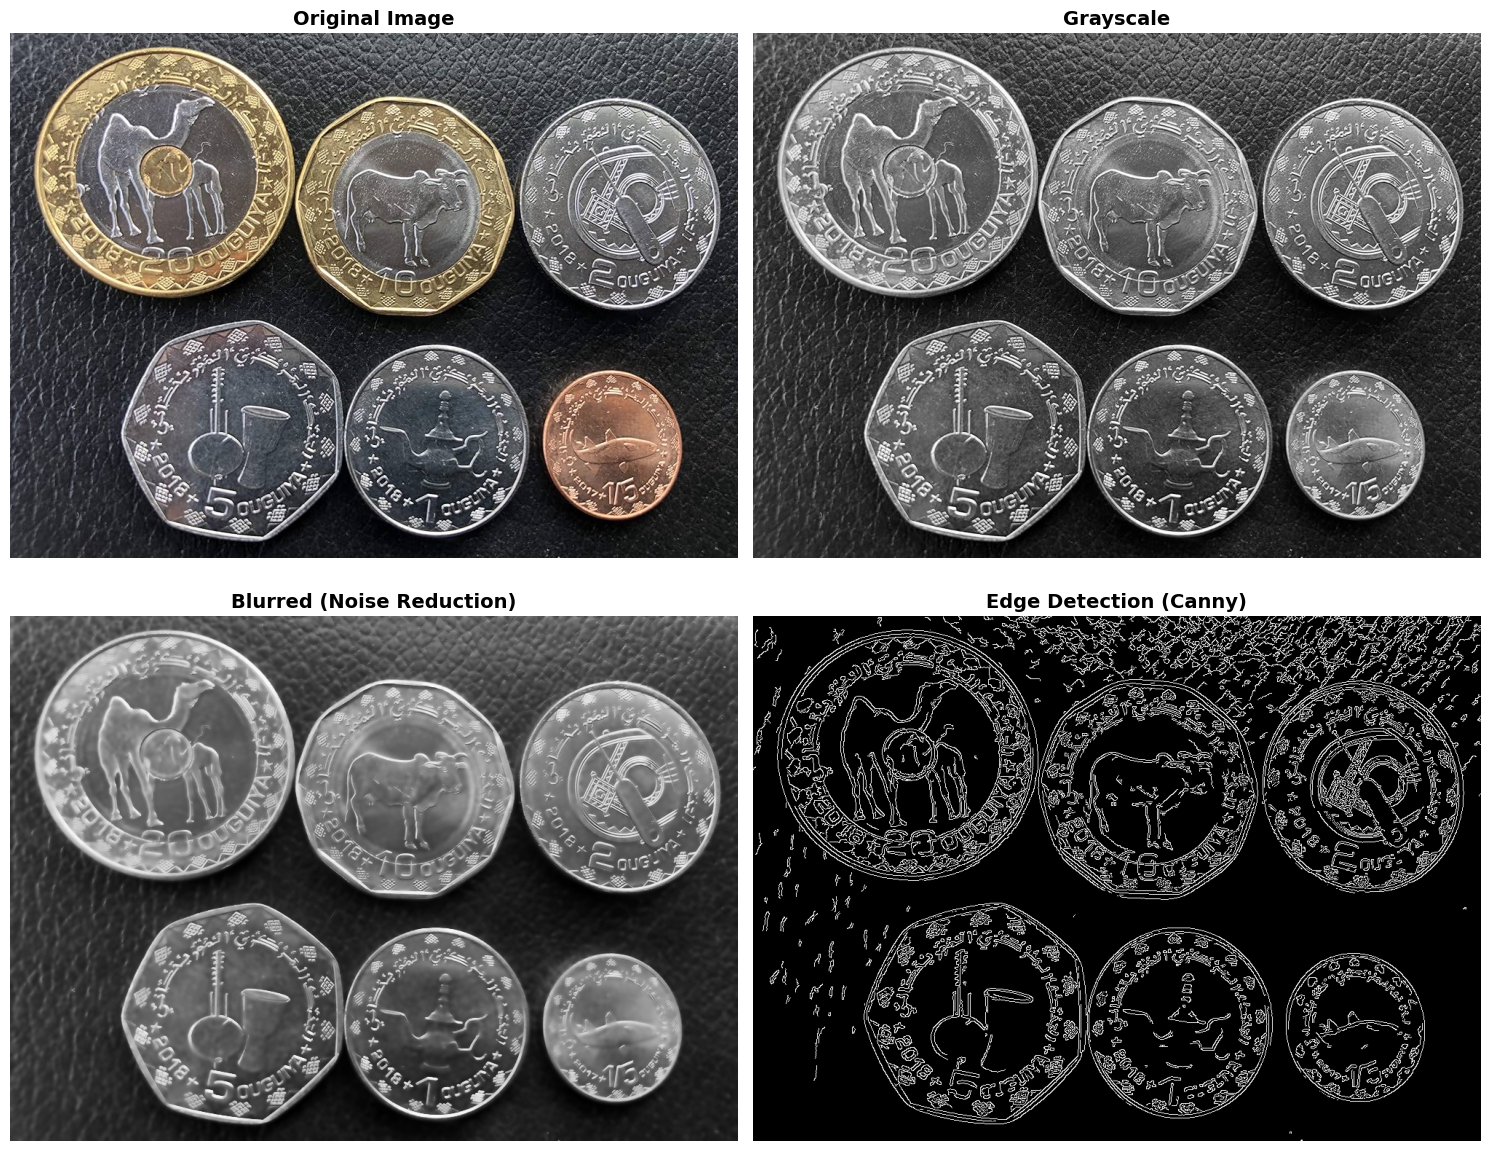


[STEP 4] Computing Gradients...
✓ Gradients computed

[STEP 5] Detecting Circles...

  → Running OpenCV CHT...
✓ OpenCV detected 405 circles

[STEP 6] Refining Circle Centers...
✓ Refined 405 circle centers

[STEP 7] Classifying Coins by Size...
✓ Classified coins into 71 types

[STEP 8] Visualizing Results...


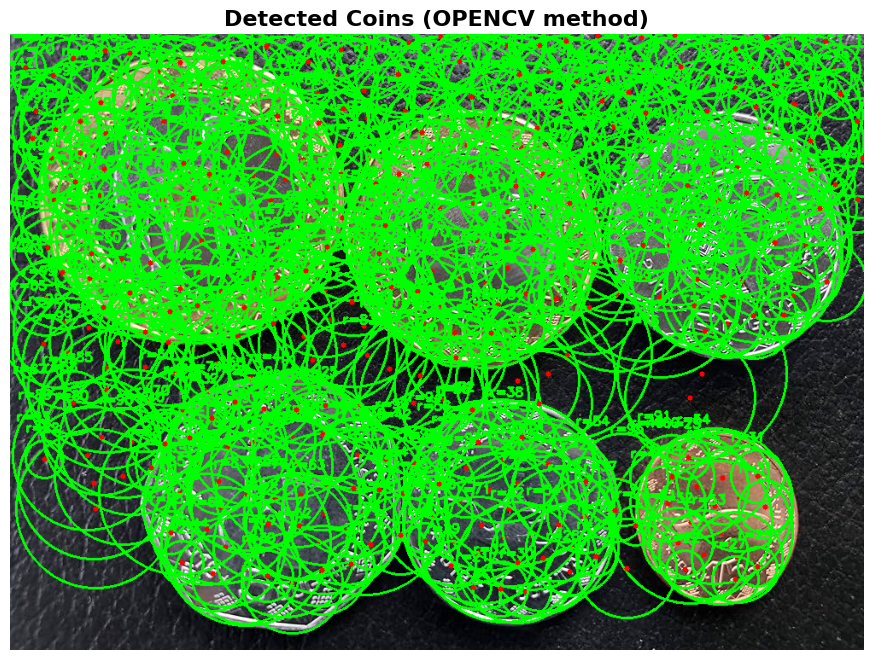

/tmp/ipython-input-1836677147.py:559: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


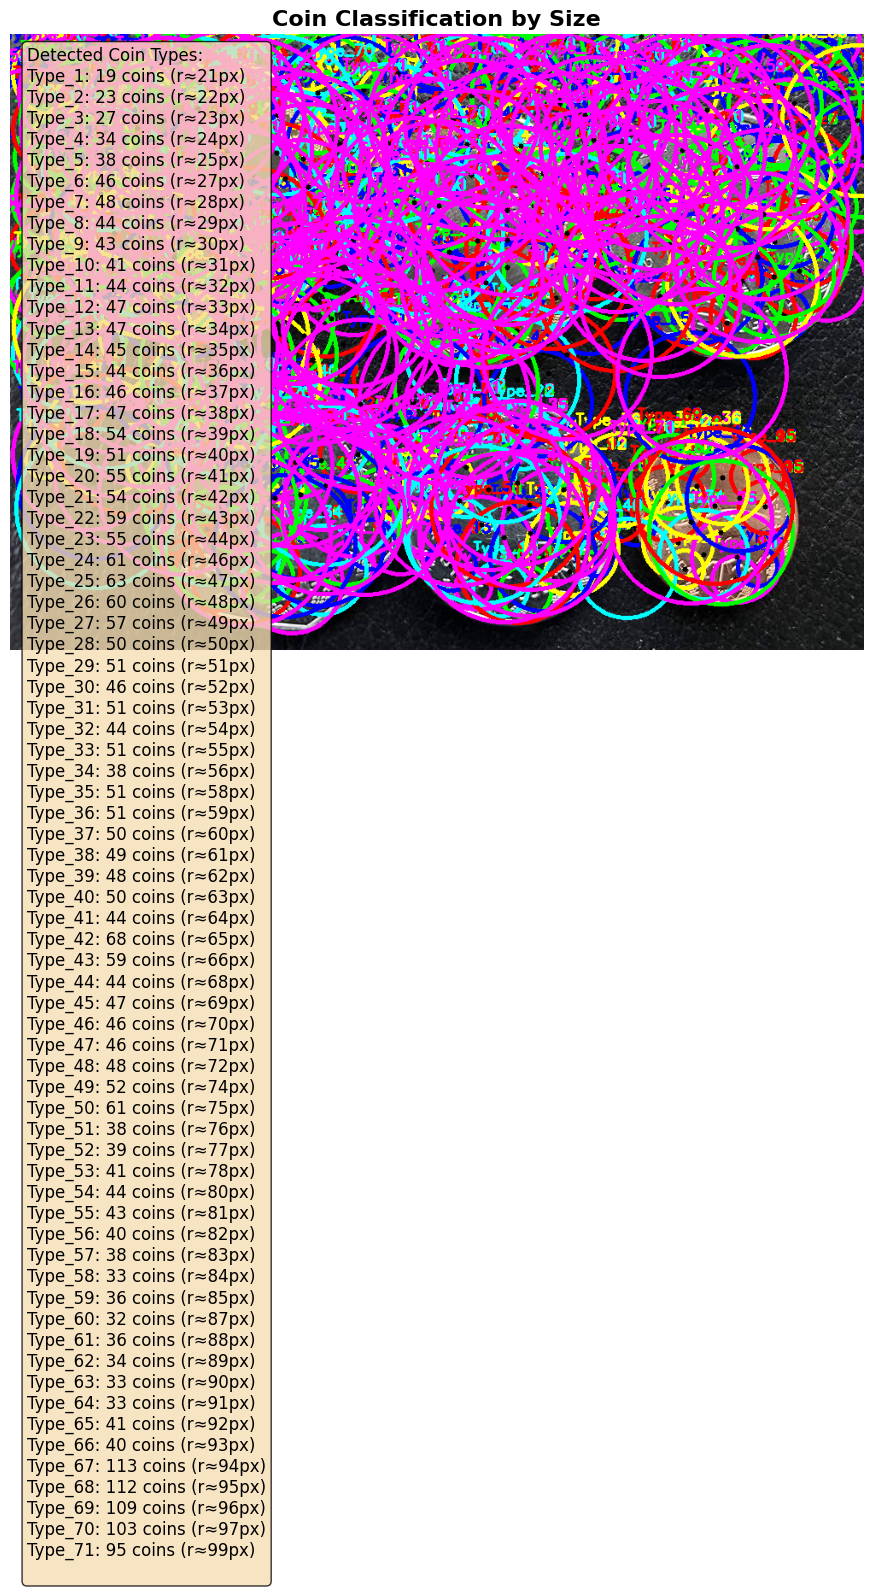


COIN DETECTION RESULTS

📊 Total Coins Detected: 405

💰 Coin Types Identified: 71

Breakdown by Type:
------------------------------------------------------------
  Type_1:
    • Count: 19 coins
    • Average Radius: 21 pixels
    • Diameter: 42 pixels
  Type_2:
    • Count: 23 coins
    • Average Radius: 22 pixels
    • Diameter: 44 pixels
  Type_3:
    • Count: 27 coins
    • Average Radius: 23 pixels
    • Diameter: 46 pixels
  Type_4:
    • Count: 34 coins
    • Average Radius: 24 pixels
    • Diameter: 48 pixels
  Type_5:
    • Count: 38 coins
    • Average Radius: 25 pixels
    • Diameter: 50 pixels
  Type_6:
    • Count: 46 coins
    • Average Radius: 27 pixels
    • Diameter: 54 pixels
  Type_7:
    • Count: 48 coins
    • Average Radius: 28 pixels
    • Diameter: 56 pixels
  Type_8:
    • Count: 44 coins
    • Average Radius: 29 pixels
    • Diameter: 58 pixels
  Type_9:
    • Count: 43 coins
    • Average Radius: 30 pixels
    • Diameter: 60 pixels
  Type_10:
    • Count: 41 

In [3]:
# ============================================================================
# COIN DETECTION & COUNTING SYSTEM USING CIRCULAR HOUGH TRANSFORM
# ============================================================================

# 1. SETUP & IMPORTS
# ============================================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files
from scipy import ndimage
import io
from PIL import Image

print("✓ All libraries imported successfully!")

# ============================================================================
# 2. IMAGE LOADING & PREPROCESSING
# ============================================================================

def load_image_from_path(image_path):
    """Load an image from a file path"""
    try:
        # Read the image using OpenCV
        image = cv2.imread(image_path)

        if image is None:
            print(f"✗ Failed to load image from: {image_path}")
            print("  Please check if the path is correct and the file exists.")
            return None, None

        print(f"✓ Loaded image from: {image_path}")
        print(f"  Image shape: {image.shape}")

        # Extract filename from path
        filename = image_path.split('/')[-1]

        return image, filename

    except Exception as e:
        print(f"✗ Error loading image: {str(e)}")
        return None, None

def load_image_from_upload():
    """Upload and load an image"""
    print("Please upload an image of coins...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Read the uploaded file
        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image = np.array(image)

        # Convert to BGR if needed (for OpenCV)
        if len(image.shape) == 2:  # Grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        elif image.shape[2] == 4:  # RGBA
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGR)
        elif image.shape[2] == 3:  # RGB
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        print(f"✓ Loaded image: {filename}")
        print(f"  Image shape: {image.shape}")
        return image, filename

    return None, None

def create_sample_coin_image():
    """Create a synthetic image with coins for testing"""
    img = np.ones((500, 600, 3), dtype=np.uint8) * 240  # Light gray background

    # Define coin positions and radii
    coins = [
        (150, 150, 50),   # (x, y, radius)
        (350, 150, 40),
        (150, 350, 45),
        (450, 200, 35),
        (350, 380, 50),
        (500, 400, 30),
    ]

    # Draw coins with realistic shading
    for (x, y, r) in coins:
        # Main coin body
        cv2.circle(img, (x, y), r, (180, 150, 100), -1)

        # Outer rim (darker)
        cv2.circle(img, (x, y), r, (120, 100, 70), 3)

        # Inner highlight (lighter)
        cv2.circle(img, (x-r//4, y-r//4), r//3, (220, 200, 180), -1)

        # Add some texture
        for i in range(5):
            angle = i * 72  # 5 points
            x1 = int(x + (r-10) * np.cos(np.radians(angle)))
            y1 = int(y + (r-10) * np.sin(np.radians(angle)))
            cv2.circle(img, (x1, y1), 2, (150, 120, 90), -1)

    print("✓ Created synthetic coin image with", len(coins), "coins")
    return img

def preprocess_image(image):
    """Preprocess image for coin detection"""
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Apply bilateral filter to reduce noise while preserving edges
    blurred = cv2.bilateralFilter(gray, 9, 75, 75)

    # Alternative: Gaussian blur
    # blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    print("✓ Image preprocessed")
    return gray, blurred

# ============================================================================
# 3. EDGE DETECTION
# ============================================================================

def detect_edges(image, method='canny', low_threshold=50, high_threshold=150):
    """Detect edges using various methods"""

    if method == 'canny':
        edges = cv2.Canny(image, low_threshold, high_threshold)
        print(f"✓ Canny edge detection applied (thresholds: {low_threshold}, {high_threshold})")

    elif method == 'sobel':
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        edges = np.sqrt(sobelx**2 + sobely**2)
        edges = np.uint8(edges / edges.max() * 255)
        _, edges = cv2.threshold(edges, low_threshold, 255, cv2.THRESH_BINARY)
        print("✓ Sobel edge detection applied")

    else:
        edges = cv2.Canny(image, low_threshold, high_threshold)
        print("✓ Default Canny edge detection applied")

    return edges

def compute_gradients(image):
    """Compute gradient magnitude and direction for gradient weighting"""
    # Sobel operators
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Gradient magnitude
    magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Gradient direction
    direction = np.arctan2(sobely, sobelx)

    print("✓ Gradients computed")
    return magnitude, direction

# ============================================================================
# 4. CIRCULAR HOUGH TRANSFORM - BASIC VERSION (OPTIMIZED)
# ============================================================================

def basic_circular_hough_transform(edges, min_radius=20, max_radius=100,
                                   threshold=0.5):
    """
    Basic implementation of Circular Hough Transform (OPTIMIZED)

    Parameters:
    - edges: Binary edge image
    - min_radius, max_radius: Range of radii to search
    - threshold: Minimum vote threshold (as fraction of circle circumference)
    """

    height, width = edges.shape

    # Initialize accumulator (3D: x, y, radius)
    radii_range = range(min_radius, max_radius + 1)
    accumulator = np.zeros((height, width, len(radii_range)))

    # Get edge points
    edge_points = np.argwhere(edges > 0)
    print(f"  Found {len(edge_points)} edge points")

    # Voting process
    print("  Voting in progress...")
    for y, x in edge_points:
        for r_idx, radius in enumerate(radii_range):
            # Vote for all possible centers at distance 'radius' from this edge point
            # OPTIMIZED: Sample every 15 degrees instead of 5 for faster processing
            for theta in range(0, 360, 15):  # Sample every 15 degrees (3x faster)
                # Possible center coordinates
                a = int(x - radius * np.cos(np.radians(theta)))
                b = int(y - radius * np.sin(np.radians(theta)))

                # Check bounds
                if 0 <= a < width and 0 <= b < height:
                    accumulator[b, a, r_idx] += 1

    print("✓ Basic CHT voting completed")
    return accumulator, radii_range

def detect_circles_from_accumulator(accumulator, radii_range, threshold_ratio=0.5,
                                   min_distance=30):
    """
    Detect circles from accumulator by finding peaks

    Parameters:
    - accumulator: 3D voting array
    - radii_range: Range of radii
    - threshold_ratio: Minimum votes as ratio of circle circumference
    - min_distance: Minimum distance between circle centers
    """

    detected_circles = []

    for r_idx, radius in enumerate(radii_range):
        # Get accumulator slice for this radius
        acc_slice = accumulator[:, :, r_idx]

        # Threshold based on expected votes (adjusted for 15-degree sampling)
        expected_votes = 2 * np.pi * radius / 15  # Divided by angular step
        threshold = threshold_ratio * expected_votes

        # Find local maxima
        peaks = acc_slice > threshold

        # Get peak coordinates
        peak_coords = np.argwhere(peaks)

        for y, x in peak_coords:
            votes = acc_slice[y, x]

            # Check if too close to existing circles
            too_close = False
            for (cx, cy, cr, cv) in detected_circles:
                distance = np.sqrt((x - cx)**2 + (y - cy)**2)
                if distance < min_distance:
                    too_close = True
                    break

            if not too_close:
                detected_circles.append((x, y, radius, votes))

    # Sort by votes (confidence)
    detected_circles.sort(key=lambda c: c[3], reverse=True)

    print(f"✓ Detected {len(detected_circles)} circles")
    return detected_circles

# ============================================================================
# 5. OPENCV HOUGH CIRCLE TRANSFORM (OPTIMIZED)
# ============================================================================

def opencv_hough_circles(image, min_radius=20, max_radius=100,
                         param1=50, param2=30, min_dist=30):
    """
    Use OpenCV's optimized HoughCircles implementation

    Parameters:
    - image: Grayscale image
    - min_radius, max_radius: Radius range
    - param1: Higher threshold for Canny edge detector
    - param2: Accumulator threshold (smaller = more circles detected)
    - min_dist: Minimum distance between circle centers
    """

    circles = cv2.HoughCircles(
        image,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=min_dist,
        param1=param1,
        param2=param2,
        minRadius=min_radius,
        maxRadius=max_radius
    )

    detected_circles = []
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            detected_circles.append((x, y, r, 100))  # Dummy vote count

        print(f"✓ OpenCV detected {len(detected_circles)} circles")
    else:
        print("✗ No circles detected by OpenCV")

    return detected_circles

# ============================================================================
# 6. GRADIENT-WEIGHTED HOUGH TRANSFORM
# ============================================================================

def gradient_weighted_hough_transform(edges, magnitude, direction,
                                     min_radius=20, max_radius=100,
                                     threshold=0.4):
    """
    Gradient-weighted CHT for more accurate detection
    Uses edge gradient information to vote only in the gradient direction
    """

    height, width = edges.shape
    radii_range = range(min_radius, max_radius + 1)
    accumulator = np.zeros((height, width, len(radii_range)))

    # Normalize magnitude for weighting
    magnitude_norm = magnitude / (magnitude.max() + 1e-6)

    # Get edge points
    edge_points = np.argwhere(edges > 0)
    print(f"  Found {len(edge_points)} edge points")

    print("  Gradient-weighted voting in progress...")
    for y, x in edge_points:
        # Get gradient direction at this point
        grad_dir = direction[y, x]
        grad_mag = magnitude_norm[y, x]

        for r_idx, radius in enumerate(radii_range):
            # Vote in gradient direction (outward from center)
            # Positive direction (outside)
            a_out = int(x + radius * np.cos(grad_dir))
            b_out = int(y + radius * np.sin(grad_dir))

            # Negative direction (inside)
            a_in = int(x - radius * np.cos(grad_dir))
            b_in = int(y - radius * np.sin(grad_dir))

            # Vote with gradient magnitude as weight
            if 0 <= a_out < width and 0 <= b_out < height:
                accumulator[b_out, a_out, r_idx] += grad_mag

            if 0 <= a_in < width and 0 <= b_in < height:
                accumulator[b_in, a_in, r_idx] += grad_mag

    print("✓ Gradient-weighted CHT completed")
    return accumulator, radii_range

# ============================================================================
# 7. ACCURATE CENTER LOCATION REFINEMENT
# ============================================================================

def refine_circle_centers(circles, edges, refinement_window=5):
    """
    Refine circle centers using local edge information
    """
    refined_circles = []

    for (x, y, r, votes) in circles:
        # Define search window
        x_min = max(0, x - refinement_window)
        x_max = min(edges.shape[1], x + refinement_window + 1)
        y_min = max(0, y - refinement_window)
        y_max = min(edges.shape[0], y + refinement_window + 1)

        # Find center of mass of edge points in window
        window = edges[y_min:y_max, x_min:x_max]

        if window.sum() > 0:
            y_coords, x_coords = np.nonzero(window)

            if len(x_coords) > 0:
                refined_x = int(x_min + x_coords.mean())
                refined_y = int(y_min + y_coords.mean())

                refined_circles.append((refined_x, refined_y, r, votes))
            else:
                refined_circles.append((x, y, r, votes))
        else:
            refined_circles.append((x, y, r, votes))

    print(f"✓ Refined {len(refined_circles)} circle centers")
    return refined_circles

# ============================================================================
# 8. COIN CLASSIFICATION BY SIZE
# ============================================================================

def classify_coins_by_size(circles, size_tolerance=5):
    """
    Classify coins into different denominations based on radius
    """
    if not circles:
        return {}

    # Group circles by similar radii
    radii = [r for (_, _, r, _) in circles]
    radii_sorted = sorted(set(radii))

    coin_types = {}
    type_id = 1

    for radius in radii_sorted:
        # Find all circles with similar radius
        similar = [c for c in circles if abs(c[2] - radius) <= size_tolerance]

        if similar:
            coin_types[f"Type_{type_id}"] = {
                'radius': radius,
                'count': len(similar),
                'circles': similar
            }
            type_id += 1

    print(f"✓ Classified coins into {len(coin_types)} types")
    return coin_types

# ============================================================================
# 9. VISUALIZATION FUNCTIONS
# ============================================================================

def visualize_steps(original, gray, blurred, edges):
    """Visualize preprocessing steps"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    axes[0, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(gray, cmap='gray')
    axes[0, 1].set_title('Grayscale', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(blurred, cmap='gray')
    axes[1, 0].set_title('Blurred (Noise Reduction)', fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(edges, cmap='gray')
    axes[1, 1].set_title('Edge Detection (Canny)', fontsize=14, fontweight='bold')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_accumulator(accumulator, radii_range, slice_indices=None):
    """Visualize accumulator slices for different radii"""

    # Convert radii_range to list if it's a range object
    radii_list = list(radii_range)

    # Set default slice indices if not provided
    if slice_indices is None:
        slice_indices = [0, len(radii_list)//2, len(radii_list)-1]

    num_slices = len(slice_indices)
    fig, axes = plt.subplots(1, num_slices, figsize=(5*num_slices, 5))

    if num_slices == 1:
        axes = [axes]

    for idx, slice_idx in enumerate(slice_indices):
        # Handle negative indices
        if slice_idx < 0:
            slice_idx = len(radii_list) + slice_idx

        # Make sure index is within bounds
        if slice_idx >= len(radii_list):
            slice_idx = len(radii_list) - 1

        acc_slice = accumulator[:, :, slice_idx]
        radius = radii_list[slice_idx]

        im = axes[idx].imshow(acc_slice, cmap='hot', interpolation='nearest')
        axes[idx].set_title(f'Accumulator (r={radius}px)', fontsize=12, fontweight='bold')
        axes[idx].axis('off')
        plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

def draw_circles_on_image(image, circles, color=(0, 255, 0), thickness=2):
    """Draw detected circles on image"""
    result = image.copy()

    for (x, y, r, votes) in circles:
        # Draw circle
        cv2.circle(result, (x, y), r, color, thickness)

        # Draw center
        cv2.circle(result, (x, y), 3, (0, 0, 255), -1)

        # Add label
        label = f"r={r}"
        cv2.putText(result, label, (x - r, y - r - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return result

def visualize_comparison(original, circles_basic, circles_opencv, circles_gradient):
    """Compare different detection methods"""
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # Basic CHT
    img1 = draw_circles_on_image(original, circles_basic, color=(0, 255, 0))
    axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'Basic CHT\n({len(circles_basic)} coins)',
                      fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # OpenCV CHT
    img2 = draw_circles_on_image(original, circles_opencv, color=(255, 0, 0))
    axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'OpenCV CHT (Optimized)\n({len(circles_opencv)} coins)',
                      fontsize=14, fontweight='bold')
    axes[1].axis('off')

    # Gradient-weighted CHT
    img3 = draw_circles_on_image(original, circles_gradient, color=(0, 255, 255))
    axes[2].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f'Gradient-Weighted CHT\n({len(circles_gradient)} coins)',
                      fontsize=14, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_coin_classification(original, coin_types):
    """Visualize classified coins by type"""
    result = original.copy()

    # Define colors for different types
    colors = [
        (255, 0, 0),    # Red
        (0, 255, 0),    # Green
        (0, 0, 255),    # Blue
        (255, 255, 0),  # Cyan
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Yellow
    ]

    for idx, (type_name, info) in enumerate(coin_types.items()):
        color = colors[idx % len(colors)]

        for (x, y, r, votes) in info['circles']:
            cv2.circle(result, (x, y), r, color, 3)
            cv2.circle(result, (x, y), 3, (0, 0, 0), -1)
            cv2.putText(result, type_name, (x - r, y - r - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Create legend
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax.set_title('Coin Classification by Size', fontsize=16, fontweight='bold')
    ax.axis('off')

    # Add legend text
    legend_text = "Detected Coin Types:\n"
    for idx, (type_name, info) in enumerate(coin_types.items()):
        legend_text += f"{type_name}: {info['count']} coins (r≈{info['radius']}px)\n"

    ax.text(0.02, 0.98, legend_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

def print_detailed_results(circles, coin_types):
    """Print detailed statistics"""
    print("\n" + "="*60)
    print("COIN DETECTION RESULTS")
    print("="*60)

    print(f"\n📊 Total Coins Detected: {len(circles)}")

    if coin_types:
        print(f"\n💰 Coin Types Identified: {len(coin_types)}")
        print("\nBreakdown by Type:")
        print("-" * 60)

        for type_name, info in coin_types.items():
            print(f"  {type_name}:")
            print(f"    • Count: {info['count']} coins")
            print(f"    • Average Radius: {info['radius']} pixels")
            print(f"    • Diameter: {info['radius']*2} pixels")

    print("\n" + "="*60)

# ============================================================================
# 10. MAIN EXECUTION PIPELINE
# ============================================================================

def main_coin_detection_pipeline(use_sample=True, method='all', image_path=None):
    """
    Main pipeline to execute coin detection

    Parameters:
    - use_sample: If True, use synthetic image; if False, upload image
    - method: 'basic', 'opencv', 'gradient', or 'all'
    - image_path: Path to image file (if provided, overrides use_sample)
    """

    print("="*60)
    print("COIN DETECTION & COUNTING SYSTEM")
    print("="*60)

    # Step 1: Load Image
    print("\n[STEP 1] Loading Image...")
    if image_path:
        # Load from path
        image, filename = load_image_from_path(image_path)
        if image is None:
            print("✗ Failed to load image")
            return
    elif use_sample:
        image = create_sample_coin_image()
    else:
        image, filename = load_image_from_upload()
        if image is None:
            print("✗ Failed to load image")
            return

    # Step 2: Preprocess
    print("\n[STEP 2] Preprocessing...")
    gray, blurred = preprocess_image(image)

    # Step 3: Edge Detection
    print("\n[STEP 3] Edge Detection...")
    edges = detect_edges(blurred, method='canny', low_threshold=50, high_threshold=150)

    # Visualize preprocessing steps
    visualize_steps(image, gray, blurred, edges)

    # Step 4: Compute Gradients (for gradient-weighted method)
    print("\n[STEP 4] Computing Gradients...")
    magnitude, direction = compute_gradients(blurred)

    # Step 5: Circle Detection
    print("\n[STEP 5] Detecting Circles...")

    circles_basic = []
    circles_opencv = []
    circles_gradient = []

    if method in ['basic', 'all']:
        print("\n  → Running Basic CHT...")
        # OPTIMIZED: Smaller radius range for faster processing
        accumulator_basic, radii_range = basic_circular_hough_transform(
            edges, min_radius=30, max_radius=50, threshold=0.4
        )
        circles_basic = detect_circles_from_accumulator(
            accumulator_basic, radii_range, threshold_ratio=0.35, min_distance=30
        )

        # Visualize accumulator
        print("\n  Visualizing Accumulator (Basic CHT)...")
        visualize_accumulator(accumulator_basic, radii_range)

    if method in ['opencv', 'all']:
        print("\n  → Running OpenCV CHT...")
        circles_opencv = opencv_hough_circles(
            blurred, min_radius=20, max_radius=100, param1=50, param2=30, min_dist=30
        )

    if method in ['gradient', 'all']:
        print("\n  → Running Gradient-Weighted CHT...")
        accumulator_gradient, radii_range_g = gradient_weighted_hough_transform(
            edges, magnitude, direction, min_radius=20, max_radius=100, threshold=0.3
        )
        circles_gradient = detect_circles_from_accumulator(
            accumulator_gradient, radii_range_g, threshold_ratio=0.3, min_distance=30
        )

        # Visualize accumulator
        print("\n  Visualizing Accumulator (Gradient-Weighted CHT)...")
        visualize_accumulator(accumulator_gradient, radii_range_g)

    # Step 6: Refine Centers
    print("\n[STEP 6] Refining Circle Centers...")
    if circles_opencv:
        circles_opencv = refine_circle_centers(circles_opencv, edges)
    if circles_gradient:
        circles_gradient = refine_circle_centers(circles_gradient, edges)

    # Step 7: Choose best result for classification
    best_circles = circles_opencv if circles_opencv else circles_gradient
    if not best_circles:
        best_circles = circles_basic

    # Step 8: Classify Coins
    print("\n[STEP 7] Classifying Coins by Size...")
    coin_types = classify_coins_by_size(best_circles, size_tolerance=5)

    # Step 9: Visualize Results
    print("\n[STEP 8] Visualizing Results...")

    if method == 'all':
        visualize_comparison(image, circles_basic, circles_opencv, circles_gradient)
    else:
        # Draw single result
        if method == 'basic':
            result_img = draw_circles_on_image(image, circles_basic)
        elif method == 'opencv':
            result_img = draw_circles_on_image(image, circles_opencv)
        else:
            result_img = draw_circles_on_image(image, circles_gradient)

        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Detected Coins ({method.upper()} method)', fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.show()

    # Visualize classification
    if coin_types:
        visualize_coin_classification(image, coin_types)

    # Step 10: Print Results
    print_detailed_results(best_circles, coin_types)

    print("\n✓ Pipeline completed successfully!")

    return {
        'image': image,
        'edges': edges,
        'circles_basic': circles_basic,
        'circles_opencv': circles_opencv,
        'circles_gradient': circles_gradient,
        'coin_types': coin_types
    }

# ============================================================================
# 11. RUN THE PROJECT
# ============================================================================

# RECOMMENDED: Use OpenCV method only (fastest and most reliable)
my_image_path = '/content/coins.jpg'
results = main_coin_detection_pipeline(image_path=my_image_path, method='opencv')

# ALTERNATIVE OPTIONS:

# Option 1: Run all methods for comparison (will take longer due to Basic CHT)
# results = main_coin_detection_pipeline(image_path=my_image_path, method='all')

# Option 2: Use gradient-weighted method (more accurate, moderate speed)
# results = main_coin_detection_pipeline(image_path=my_image_path, method='gradient')

# Option 3: Use synthetic test image with all methods
# results = main_coin_detection_pipeline(use_sample=True, method='all')

# Option 4: Upload your own image
# results = main_coin_detection_pipeline(use_sample=False, method='opencv')